<a href="https://colab.research.google.com/github/Hamada-Gado/IEEE-GUC-Deep-Learning-Tasks/blob/main/IEEE_Session_2_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we're going to use Pytorch to train a logistic regression model. 

This notebook won't be exploring the real power of deep neural networks we won't have any hidden layers so it's not "deep" and it can't represent nonlinear relationships in the data.

The code, however, is very much similar to what deep neural network code looks like, that is, most of the code you use here you will be useful when writing code for a deep neural network. 

This notebook just helps get you familiar with the main steps of defining and training a neural network in Pytorch.

We will compare it with the last week's model which was implemented using classical machine learning libraries (scikit-learn).

We'll start by importing PyTorch and its related packages 

In [1]:
import math

import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, accuracy_score, classification_report

# set default device based on CUDA's availability
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

we will now load the data, but skip looking at it as we did in the pervious week.

In [2]:
cat_columns: list[str] = ["Gender", "Embarked"]
num_columns: list[str] = ["Pclass", "Age", "SibSp", "Parch"]

# Create a pipeline for the categorical columns using OneHotEncoder
cat_pipeline: Pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))


# Create a pipeline for the numerical columns using MinMaxScaler
num_pipeline: Pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler())

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns),
])

In [3]:
train_data = pd.read_csv("./train.csv")
train_data = train_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis= 1)
X = train_data.drop('Survived', axis= 1)

X_train, X_test, y_train, y_test = train_test_split(X, train_data['Survived'], test_size=0.2, random_state=42)

X_train = preprocessing.fit_transform(X_train)
X_test = preprocessing.transform(X_test)

now we will transform the data into a tensor, and then we will split it into training and testing sets.

In [4]:
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)

Next we'll define a very simple class to load the data, it loads the data, then defines the `__len__` method to get its size and the `__getitem__` method to get a single example and its ground truth

In [5]:
class LogisticDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return self.X.size()[0]
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]


We'll use PyTorch's `DataLoader` class to generate the dataloader for our training data. We give it as input an instance of our dataset and specify the `batch_size` and set `shuffle=True` so that it provides batches in random order. 

In [6]:
batch_size = 4
train_dataloader = DataLoader(LogisticDataset(X_train, y_train), batch_size=batch_size, shuffle=True)


We can now loop through the dataloader to get batches of data at each iteration. 

In [7]:
for i, (data, label) in enumerate(train_dataloader):
    print(data)
    print(label)
    break


tensor([[0.0000, 0.3968, 0.0000, 0.0000, 0.0000, 1.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 0.0450, 0.1250, 0.1667, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.3466, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.3466, 0.1250, 0.0000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000]],
       device='cuda:0')
tensor([1., 1., 0., 1.], device='cuda:0')


Do note that each time we loop through the data, it will have different order. That's because we've set shuffle=True. This helps the model become more robust as it gets batches in a different order in each epoch (pass through the training data so it reduces overfitting.

In [8]:
for i, (data, label) in enumerate(train_dataloader):
    print(data)
    print(label)
    break


tensor([[0.0000, 0.2586, 0.0000, 0.1667, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.5979, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 0.3340, 0.0000, 0.3333, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000],
        [0.5000, 0.3466, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 1.0000, 0.0000]],
       device='cuda:0')
tensor([0., 0., 1., 1.], device='cuda:0')


If we count how many iterations we go through in train_dataloader we find that it does 223 iterations. That's because we have a total of 891 examples and a `batch_size` of 4. Changing the batch size should affect the number of iterations, which are generally `number of examples / batch_size`

In [9]:
counter = 0
for i, (data, label) in enumerate(train_dataloader):
    pass
print(i + 1)


178


**Defining the Logistic Regression model using Pytorch**

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self, num_inputs=9, num_outputs=1, **kwargs):
        super(LogisticRegression, self).__init__(**kwargs)
        # The layer should have an input of shape 9 and an output of shape 1

        # If we use only this layer, the model will be exactly like the previous week logistic regression model
        # self.fc1 = nn.Linear(num_inputs, num_outputs, bias=True)

        # This will be the code of a more complex model
        self.fc1 = nn.Linear(num_inputs, 256, bias=True)
        self.fc2 = nn.Linear(256, 128, bias=True)
        self.fc3 = nn.Linear(128, 64, bias=True)
        self.fc4 = nn.Linear(64, num_outputs, bias=True)

    def forward(self, x):
        x = self.fc1(x)

        # This will be the code of a more complex model
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        ###############################################

        x = torch.sigmoid(x)
        x = x.squeeze(1) # remove the last dimension
        return x


net = LogisticRegression()
net.to(device)

LogisticRegression(
  (fc1): Linear(in_features=9, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

**Use Binary Categorical Cross-Entropy loss**

In [11]:
loss_fn = nn.BCELoss(reduction='mean')

**Use Stochastic Gradient Descent for optimizing the model**

In [12]:
optimizer = optim.SGD(net.parameters(), lr= 1e-2, momentum= 0.9)

**Complete the training loop and train the model**

In [13]:
num_examples = len(train_data)
epochs = 200
num_batches = math.ceil(num_examples / batch_size)
losses = []

for epoch in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_dataloader):
        data = data.to(device)
        label = label.to(device)

        
        yhat = net(data)
        loss = loss_fn(yhat, label) # Call the loss function you defined earlier
        
        # Call the zero_grad method of the optimizer you defined
        optimizer.zero_grad()

        # Call the backward method of the loss tensor you just calculated
        loss.backward()

        # Call the step method of the optimizer 
        optimizer.step()

        cumulative_loss += loss.item()
    print("Epoch %s, loss: %s" % (epoch, cumulative_loss / num_examples))
    losses.append(cumulative_loss / num_batches)


Epoch 0, loss: 0.11672872766501173
Epoch 1, loss: 0.09541858739389983
Epoch 2, loss: 0.09298243741980439
Epoch 3, loss: 0.09029580070715561
Epoch 4, loss: 0.09182222580117007
Epoch 5, loss: 0.09005528883266395
Epoch 6, loss: 0.08848419870165261
Epoch 7, loss: 0.08889503803785669
Epoch 8, loss: 0.08924372266773155
Epoch 9, loss: 0.08932141966356841
Epoch 10, loss: 0.08909844472485895
Epoch 11, loss: 0.08860115024577889
Epoch 12, loss: 0.08926226511413668
Epoch 13, loss: 0.08776998545819795
Epoch 14, loss: 0.08706712225654845
Epoch 15, loss: 0.08594382821041861
Epoch 16, loss: 0.08776629334848737
Epoch 17, loss: 0.08525309366342328
Epoch 18, loss: 0.08560076037340293
Epoch 19, loss: 0.08496314804378048
Epoch 20, loss: 0.08402814089365546
Epoch 21, loss: 0.08354135108515871
Epoch 22, loss: 0.0844240513129534
Epoch 23, loss: 0.08463473656704998
Epoch 24, loss: 0.0838024882405294
Epoch 25, loss: 0.08305692242084262
Epoch 26, loss: 0.0848029386482121
Epoch 27, loss: 0.08398306962650365
Epoch

Now we can plot the average loss of the model for each epoch it trained.

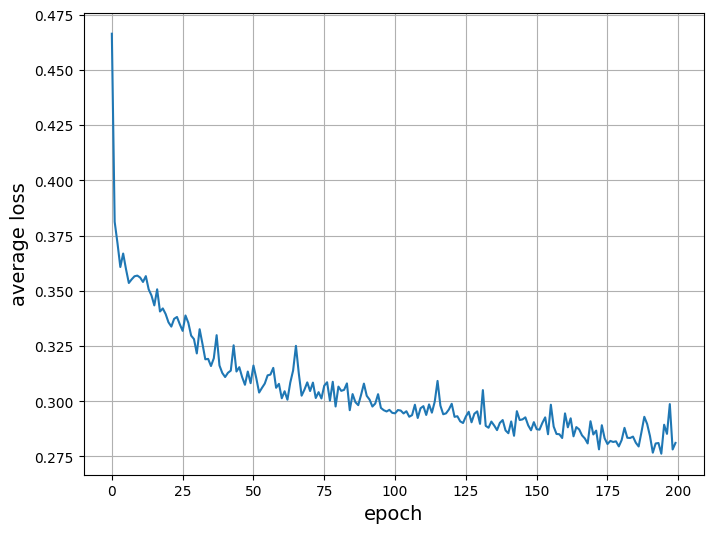

In [14]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()


In [15]:
predictions = (
    net(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().detach().numpy()
)
predictions = (predictions > 0.5).astype(int)

log_loss_ = log_loss(y_test, predictions)
acc_score = accuracy_score(y_test, predictions)

print(f"Log loss: {log_loss_}")
print(f"Accuracy score: {acc_score}")
print(classification_report(y_test, predictions))

Log loss: 6.443558147775134
Accuracy score: 0.8212290502793296
              precision    recall  f1-score   support

           0       0.80      0.92      0.86       105
           1       0.86      0.68      0.76        74

    accuracy                           0.82       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.82      0.82       179

